In [38]:
import math
import pickle
import copy
import gzip
import pandas as pd
import numpy as np
import random
from pymatgen.util import coord
from pymatgen.io.ase import AseAtomsAdaptor
from ase.visualize.plot import plot_atoms
from matplotlib import pyplot as plt
from pymatgen.core.structure import Structure
from pymatgen.core.periodic_table import Element
from pymatgen.core.sites import Site
from scipy.stats import maxwell

In [51]:
#You can choose the number of defects
numOfDef = 3

In [40]:
# Fucntion that prints the structure based on it's initial_structure
def printStructure(d):
    s0 = d.initial_structure
    d0 = list(d.defect_representation)
    ase_atoms = AseAtomsAdaptor.get_atoms(s0)
    fig, ax = plt.subplots()
    plot_atoms(ase_atoms, ax, radii=0.6, rotation=('10x, 0y, 0z'), show_unit_cell=True)
    xlim = 40
    ylim = 23
    ax.set_xlim(-2, xlim)
    ax.set_ylim(-2, ylim)
#     ax.set_title(f'{d0}')

In [41]:
#Function, that sets the first defect
def SettingFirstDefect(numOfDef):
    l = []
    while True:
        if numOfDef == 0:
            break
        x = np.random.randint(0, 64)
        if x in l:
            continue
        else:
            l.append(x)
            numOfDef -= 1
    return l

In [42]:
 # Counts Defect Interaction Energy based on the distance between two defects
def Defect_Interaction_Energy(x):
    print("Расстояние = ", x)
    E = (((x * (math.cos(0.5) * ((math.cos(((0.5 * (4 * (x * (4 - x)))) / x)) * x) / x))) - x) / ((math.exp(x)) / x))
    print("Результат = ", E)
    return E

In [43]:
#Function, that detects the probability of jump and return 1 or 0
def RandJump(energy_of_barrier, loc, scale):
    prob = 1 - maxwell.cdf(energy_of_barrier, loc, scale) 
    print("Вероятность скачка: ", prob)
#     print (random.choices([0, 1], [1 - prob, prob]))
    return(random.choices([0, 1], [1 - prob, prob])[0])

In [44]:
#Main Rand fucntion which uses funcs RandJump and Defect_Interaction_Energy
#This function equiprobably chooses where defect will go
#and then with RandJump chooses whether the event happens
#connection - словарь с ключом - рассматриваевым дефектом и значениями -
#другими дефектами, которые влияют на данный дефект
def Rand(connection):
    a = np.random.randint(0, 7)
    
    E_pot = 0.94
    e = 1.60217663 * 10 ** (-19)
    m_electon = 9.1093837 * 10 ** (-34)
    m = 1.5932871 * 10 ** (-22)
    k = 1.380649 * 10 ** (-23)
    T = 700
    
    loc = math.sqrt(2 * m * k * T)
    
    scale = math.sqrt(m * k * T)
    energy_of_interaction = 0

    
    
    x1 = list(connection.keys())[0].coords[0]
    y1 = list(connection.keys())[0].coords[1]
    x = list()
    y = list()
    for i in list(connection.values())[0]:
        x.append(i.coords[0])
        y.append(i.coords[1])
    rast = list()
        
    if a == 0:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 - 1.5952 - x[i]) ** 2 + (y1 - 2.7629 - y[i]) ** 2)) # must be corrected
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 - 1.5952 - x[i]) ** 2 + (y1 - 2.7629 - y[i]) ** 2))
            
            
        energy_of_barrier = math.sqrt(2 * (E_pot + energy_of_interaction) * e * m)  # It is initially an momentum to jump through the barrier
            
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([-1.5952, -2.7629, 0])
        else: res = np.array([0, 0, 0])
            
            
    elif a == 1:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 - 2 * 1.5952 - x[i]) ** 2 + (y1 - y[i]) ** 2))
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 - 2 * 1.5952 - x[i]) ** 2 + (y1 - y[i]) ** 2))
            
        energy_of_barrier = math.sqrt(2 * (E_pot + energy_of_interaction) * e * m)
            
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([-2 * 1.5952, 0, 0])
        else: res = np.array([0, 0, 0])
        
    elif a == 2:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 - 1.5952 - x[i]) ** 2 + (y1 + 2.7629 - y[i]) ** 2))
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 - 1.5952 - x[i]) ** 2 + (y1 + 2.7629 - y[i]) ** 2))
            
        energy_of_barrier = math.sqrt(2 * (E_pot + energy_of_interaction) * e * m)

        
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([-1.5952, 2.7629, 0])
        else: res = np.array([0, 0, 0])
        
    elif a == 3:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 + 1.5952 - x[i]) ** 2 + (y1 + 2.7629 - y[i]) ** 2))
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 + 1.5952 - x[i]) ** 2 + (y1 + 2.7629 - y[i]) ** 2))
            
        energy_of_barrier = math.sqrt(2 * (E_pot + energy_of_interaction) * e * m)

        
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([1.5952, 2.7629, 0])
        else: res = np.array([0, 0, 0])

    elif a == 4:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 + 2 * 1.5952 - x[i]) ** 2 + (y1 - y[i]) ** 2))
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 + 2 * 1.5952 - x[i]) ** 2 + (y1 - y[i]) ** 2))
            
        energy_of_barrier = math.sqrt(2 * (E_pot + energy_of_interaction) * e * m)
        
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([2 * 1.5952, 0, 0])
        else: res = np.array([0, 0, 0])
            
    elif a == 5:
        for i in range(len(x)):
            rast.append(math.sqrt((x1 + 1.5952 - x[i]) ** 2 + (y1 - 2.7629 - y[i]) ** 2))
            energy_of_interaction += Defect_Interaction_Energy(math.sqrt((x1 + 1.5952 - x[i]) ** 2 + (y1 - 2.7629 - y[i]) ** 2))
            
        energy_of_barrier = math.sqrt(2 * (E_pot + energy_of_interaction) * e * m)
        
        if RandJump(energy_of_barrier, loc, scale) == 1:
            res = np.array([1.5952, -2.7629, 0])
        else: res = np.array([0, 0, 0])

    elif a == 6:
        res = np.array([0, 0, 0])
        energy_of_barrier = math.sqrt(2 * E_pot * e * m)
        
        
    print('loc = ', loc, 'energy_of_barrier = ', energy_of_barrier, 'scale = ', scale)

    print("Барьер: ", E_pot + energy_of_interaction, '\n')
    return res

In [45]:
# Creating new structure with one defect based in function Rand() and old structure
def newDefects(olddata):

    
    newdata = pd.read_pickle('emptydata.pkl')
    newdata = newdata.iloc[0]
    newdata.defect_representation.clear()
    
    DefWithNoChanges = 0
    for i in range(len(list(olddata.defect_representation))):
        print(f"Defect number {i}")
        while True:
            connection = dict()
            connection = {olddata.defect_representation[i] : olddata.defect_representation[:i] + olddata.defect_representation[i+1:]}
#             print(connection)
            newPositionCoords = Rand(connection)
            ###
            if np.array_equal(newPositionCoords, np.array([0,0,0])):
                DefWithNoChanges += 1
            ###
            newcoord = (olddata.defect_representation[i].coords + newPositionCoords)
            if (newcoord[0] + (newcoord[1] / 1.732) < 24) and (newcoord[0] + newcoord[1] / 1.732 > 0) and (-12 < newcoord[0] < 23) and (1 < newcoord[1] < 22):
                break
        index = np.where ((np.round(olddata.initial_structure.cart_coords[:,0], 1) 
                     == np.round(newcoord[0], 1))
                    & (np.round(olddata.initial_structure.cart_coords[:,1], 1) 
                     == np.round(newcoord[1], 1)))
        index = index[0][0]
        newdata.initial_structure.replace(index, Element('W'))
        newdata.defect_representation.append(newdata.initial_structure[index].species, newdata.initial_structure[index].frac_coords)
    if DefWithNoChanges == numOfDef:
        return False
    return newdata

In [52]:
#Reading the structure with no defects 
dataBegin = pd.read_pickle('emptydata.pkl')
dataBegin = dataBegin.iloc[0]
dataBegin.defect_representation.clear()

In [53]:
# Setting Randomly first defect
l = SettingFirstDefect(numOfDef)
for i in range(len(l)):
    dataBegin.initial_structure.replace(l[i], Element('W'))
    dataBegin.defect_representation.append(dataBegin.initial_structure[l[i]].species, dataBegin.initial_structure[l[i]].frac_coords)

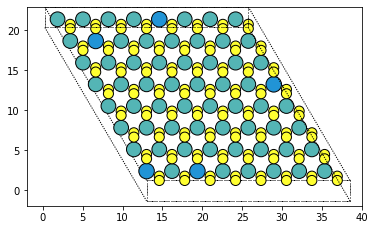

In [54]:
printStructure(dataBegin)

Defect number 0
Расстояние =  22.332209379315923
Результат =  -5.506078093061039e-08
Расстояние =  11.051617051005902
Результат =  -0.0018796138728526704
Расстояние =  22.3322214221701
Результат =  -5.5058363813266094e-08
Расстояние =  16.881535667968485
Результат =  -3.8658805618144914e-06
Вероятность скачка:  0.000604573331383973
loc =  1.754901233078107e-21 energy_of_barrier =  6.920629196416082e-21 scale =  1.2409025622221635e-21
Барьер:  0.9381164101274407 

Defect number 1
Расстояние =  17.762936014645227
Результат =  -1.000764024191625e-05
Расстояние =  19.923541679517353
Результат =  -1.790480429111618e-07
Расстояние =  8.440823593182479
Результат =  -0.026935532989095005
Расстояние =  11.502813610777169
Результат =  -0.0022319654041665993
Вероятность скачка:  0.0008317980818012272
loc =  1.754901233078107e-21 energy_of_barrier =  6.819209690577677e-21 scale =  1.2409025622221635e-21
Барьер:  0.9108223149184536 

Defect number 2
Расстояние =  11.051617051005904
Результат =  -0.

<ipython-input-40-0092ca43c4f1>:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Defect number 0
Расстояние =  8.440784389821891
Результат =  -0.026935791760156483
Расстояние =  6.380657288205149
Результат =  -0.06600779504522339
Расстояние =  11.502853191978437
Результат =  -0.0022319524018485286
Расстояние =  14.619820745269886
Результат =  -0.00015694306590725352
Вероятность скачка:  0.0017849042670132764
loc =  1.754901233078107e-21 energy_of_barrier =  6.566895582615449e-21 scale =  1.2409025622221635e-21
Барьер:  0.8446675177268643 

Defect number 1
Расстояние =  11.502870139581516
Результат =  -0.0022319468324051082
Расстояние =  14.61989069638309
Результат =  -0.00015694160437304484
Расстояние =  5.525861890686315
Результат =  -0.22789134613761897
Расстояние =  13.906186385104691
Результат =  -8.808243353984583e-05
Вероятность скачка:  0.008067688738217726
loc =  1.754901233078107e-21 energy_of_barrier =  6.019129854411368e-21 scale =  1.2409025622221635e-21
Барьер:  0.709631682992063 

Defect number 2
Расстояние =  6.380657288205147
Результат =  -0.0660077

ValueError: math domain error

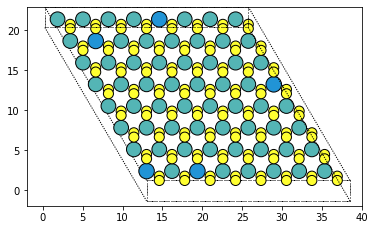

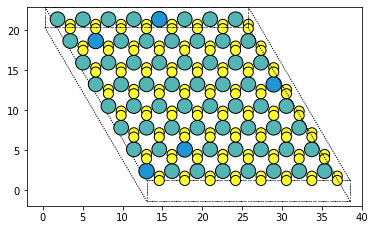

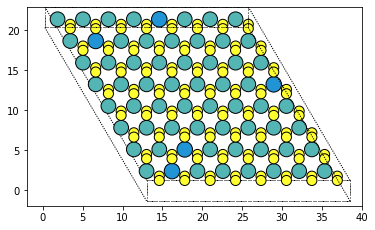

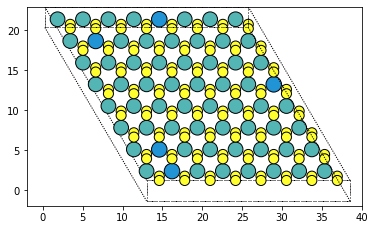

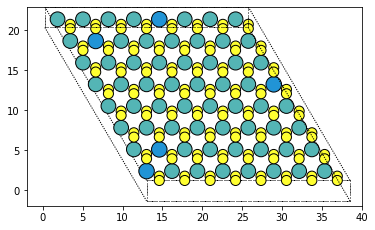

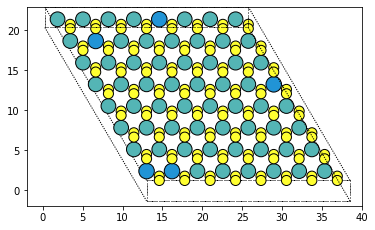

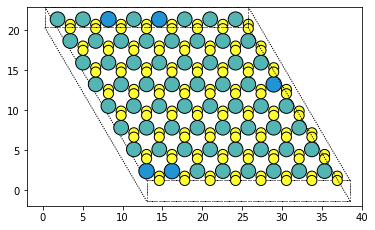

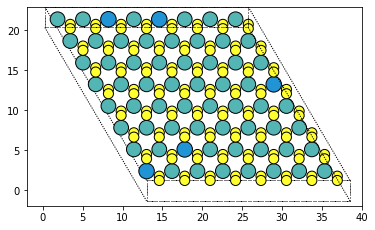

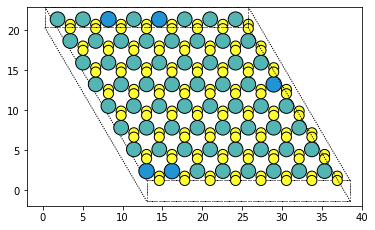

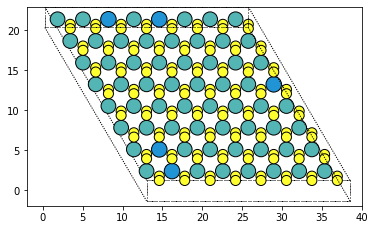

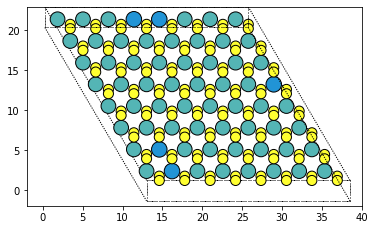

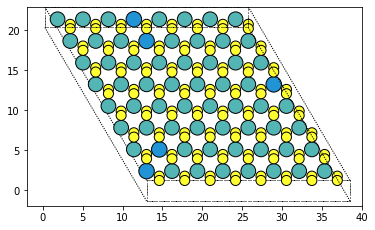

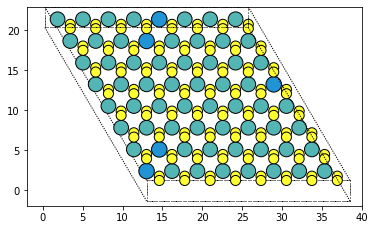

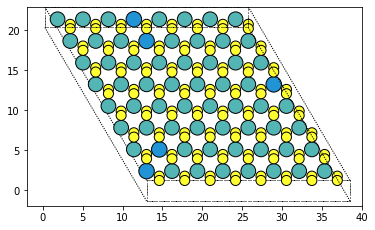

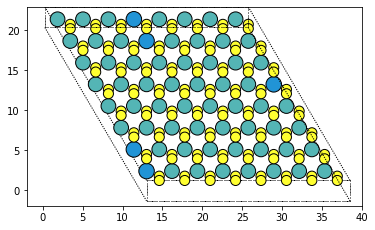

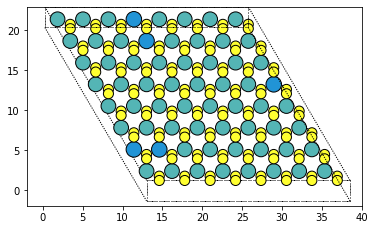

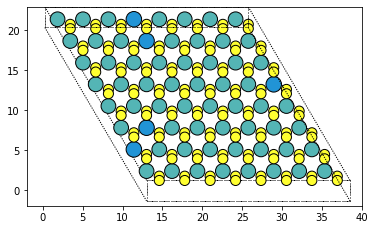

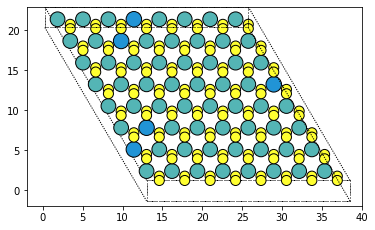

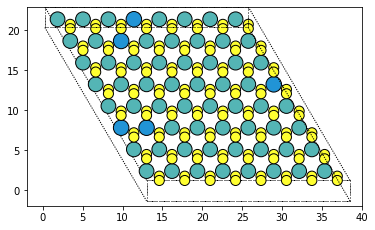

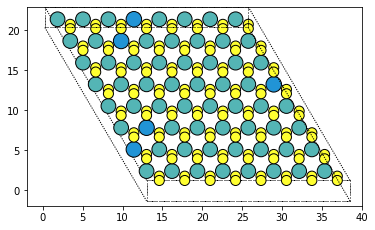

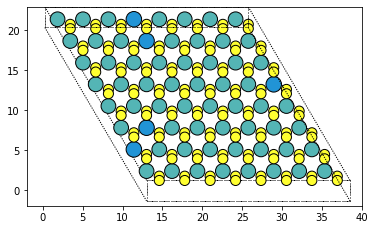

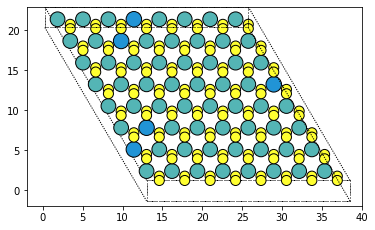

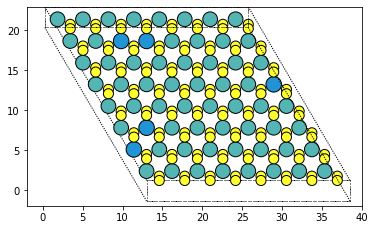

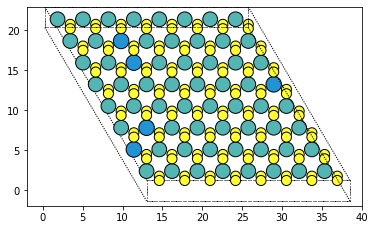

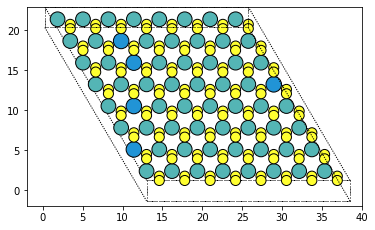

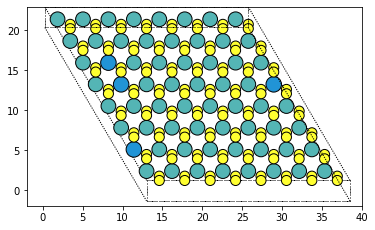

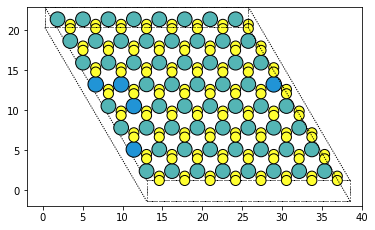

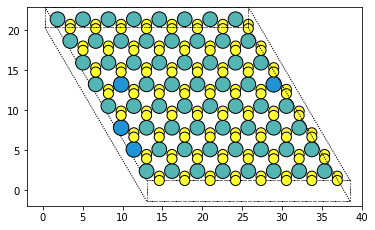

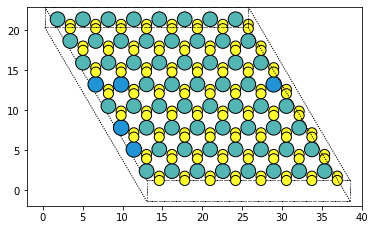

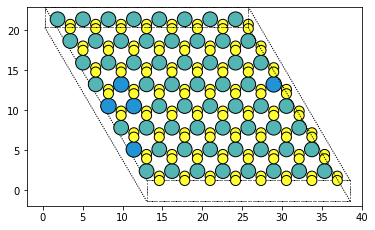

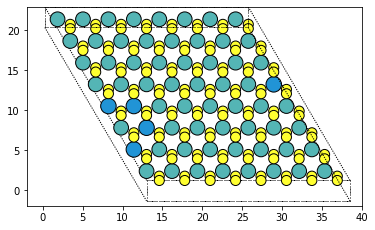

In [56]:
# Creating a list of structures with defects
datamain = pd.DataFrame()
datamain = datamain.append(dataBegin)
olddata = dataBegin.copy()
printStructure(olddata)
k = 0
for i in range(300):    
    newdata = newDefects(olddata)
    ### doesn't print with no new position
    if type(newdata) != bool:
        datamain = datamain.append(newdata)
        olddata = newdata
        printStructure(newdata)
    else:
        k += 1
        print(f"There is no changes {k} times")
    
    
    ###
    
#     datamain = datamain.append(newdata)
#     olddata = newdata
#     printStructure(newdata)

In [50]:
datamain

,descriptor_id,energy,energy_per_atom,fermi_level,homo,lumo,defect_representation,formation_energy,initial_structure,formation_energy_per_site,band_gap
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[11.16610508 15.65640177 3.719751 ] W, [-4....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[11.16610508 15.65640177 3.719751 ] W, [-4....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[ 9.57094723 18.41929621 3.719751 ] W, [-4....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[ 9.57094723 18.41929621 3.719751 ] W, [-4....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[ 9.57094723 18.41929621 3.719751 ] W, [-4....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
...,...,...,...,...,...,...,...,...,...,...,...
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[-6.38063127 18.41929621 3.719751 ] W, [-6....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[-6.38063127 18.41929621 3.719751 ] W, [-7....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[-6.38063127 18.41929621 3.719751 ] W, [-7....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
0,6141cf15c819ca30b196b471,-1400.023811,-7.291791,-0.194139,-0.7016,1.0985,"[[-4.78547342 15.65640177 3.719751 ] W, [-7....",0.166689,[[1.27612629e-07 1.84192955e+00 3.71975100e+00...,0.166689,1.8001
